In [20]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import time
# Load the OTU table file
otu_table = pd.read_csv('genus_rotated_f.csv', header=0, index_col=None)

otu_table_proportions = otu_table.div(otu_table.sum(axis=1), axis=0)
# Convert proportions to percentages
otu_table_percentages = otu_table_proportions * 100
# standardized_otu_table.to_csv('standardized_genus_rotated_f.csv', index=False)

# print(standardized_otu_table.shape)
# Create a dictionary to map genus names to unique indices
genus_names = otu_table_percentages.columns.tolist()
genus_to_idx = {genus: idx for idx, genus in enumerate(genus_names)}

class OTUDataset(Dataset):
    def __init__(self, data, genus_to_idx, mask_prob=0.05):
        self.data = data
        self.genus_to_idx = genus_to_idx
        self.mask_prob = mask_prob

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        counts = self.data.iloc[idx].tolist()
        input_ids = [self.genus_to_idx[genus] for genus in self.genus_to_idx]
        masked_ids, masked_labels = self.random_mask(counts)
        
        return {
            'input_ids': torch.tensor(input_ids, dtype=torch.long),
            'labels': torch.tensor(counts, dtype=torch.float),
            'masked_labels': torch.tensor(masked_labels, dtype=torch.float)
        }
    
    def random_mask(self, counts):
        masked_labels = []
        masked_counts = counts.copy()
        for i in range(len(counts)):
            if np.random.rand() < self.mask_prob:
                masked_labels.append(counts[i])
                masked_counts[i] = 99999999999  # Masking this value
            else:
                masked_labels.append(99999999999)  # Not a target for prediction
        return masked_counts, masked_labels



In [21]:
# class SimpleTransformerModel(nn.Module):
#     def __init__(self, vocab_size, d_model, nhead, num_encoder_layers, dim_feedforward, max_seq_length):
#         super(SimpleTransformerModel, self).__init__()
#         self.embedding = nn.Embedding(vocab_size, d_model)
#         self.pos_encoder = nn.Embedding(max_seq_length, d_model)
#         encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
#         self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
#         self.regressor = nn.Linear(d_model, vocab_size)
    
#     def forward(self, src, masked_labels=None, compute_loss=True):
#         # Ensure src is of type long
#         src = src.long()  # Convert src to long if necessary

#         # Positional encoding
#         positions = torch.arange(src.size(1), device=src.device).unsqueeze(0).repeat(src.size(0), 1)
#         src = self.embedding(src) + self.pos_encoder(positions)
        
#         # Encoder
#         output = self.transformer_encoder(src)
#         output = output[:, 0, :]  # Use the first token representation for regression
        
#         if compute_loss:
#             # Regression
#             logits = self.regressor(output) # vector
            
#             # Loss calculation 
#             loss = nn.MSELoss()(logits, masked_labels)
#             #loss = nn.MSELoss()() 
            
#             return loss, logits
#         else:
#             return output
class SimpleTransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_encoder_layers, dim_feedforward, max_seq_length, relation_matrix):
        super(SimpleTransformerModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)
        self.pos_encoder = nn.Embedding(max_seq_length, d_model)
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead, dim_feedforward)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_encoder_layers)
        self.regressor = nn.Linear(d_model, vocab_size)
        self.register_buffer('relation_matrix', relation_matrix)

    def forward(self, src, masked_labels=None, compute_loss=True):
        src = src.long()  # Ensure src is of type long

        # Positional encoding
        positions = torch.arange(src.size(1), device=src.device).unsqueeze(0).repeat(src.size(0), 1)
        src = self.embedding(src) + self.pos_encoder(positions)
        
        # Ensure relation_matrix is on the same device as src
        relation_matrix = self.relation_matrix.to(src.device)

        # Apply relation matrix to embeddings
        batch_size, seq_len, d_model = src.size()
        relation_embeddings = relation_matrix.unsqueeze(0).expand(batch_size, -1, -1)
        src = torch.bmm(relation_embeddings, src)
        
        # Encoder
        output = self.transformer_encoder(src)
        
        output = output[:, 0, :]  # Use the first token representation for regression
        
        if compute_loss:
            # Regression
            logits = self.regressor(output)  # vector

            # Loss calculation 
            mask = (masked_labels != -1)  # Create a mask to identify the positions to consider
            masked_logits = logits[mask]
            masked_labels = masked_labels[mask]
            # print(masked_labels)
            loss = nn.MSELoss()(masked_logits, masked_labels)
            
            return loss, logits
        else:
            return output




In [22]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
def generate_relation_matrix(num_species):
    # 初始化一个单位矩阵
    relation_matrix = np.eye(num_species)
    
    # 手动设置特定species之间的关系
    # 假设 Genus_A 和 Genus_B 关系紧密，值为0.8；Genus_A 和 Genus_C 关系较疏远，值为0.1；Genus_C 和 Genus_D 关系紧密，值为0.9
    # 其余关系设为中等程度，例如0.2
    relation_matrix[0, 1] = 0
    relation_matrix[1, 0] = 0
    
    relation_matrix[0, 2] = 0
    relation_matrix[2, 0] = 0
    
    relation_matrix[2, 3] = 0
    relation_matrix[3, 2] = 0
    
    relation_matrix[0, 3] = 0
    relation_matrix[3, 0] = 0
    
    relation_matrix[1, 2] = 0
    relation_matrix[2, 1] = 0
    
    relation_matrix[1, 3] = 0
    relation_matrix[3, 1] = 0
    
    # 对矩阵进行归一化处理，使其每行和为1
    relation_matrix = relation_matrix / relation_matrix.sum(axis=1, keepdims=True)
    print(relation_matrix)
    
    return torch.tensor(relation_matrix, dtype=torch.float32)
# Create a dataset and dataloader
dataset = OTUDataset(otu_table_percentages, genus_to_idx)
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)

vocab_size = len(genus_to_idx)
relation_matrix = generate_relation_matrix(vocab_size)
d_model = 256
nhead = 8
num_encoder_layers = 6
dim_feedforward = 256
max_seq_length = otu_table_percentages.shape[1]
num_epochs = 3
model = SimpleTransformerModel(vocab_size, d_model, nhead, num_encoder_layers, dim_feedforward, max_seq_length, relation_matrix).to(device)
optimizer = Adam(model.parameters(), lr=1e-4)
# model

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


label =  tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
masked label = tensor([[ 0., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1.,  0., -1.],
        [ 0., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]], device='cuda:0')
label =  tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
masked label = tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]], device='cuda:0')
label =  tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0')
maske

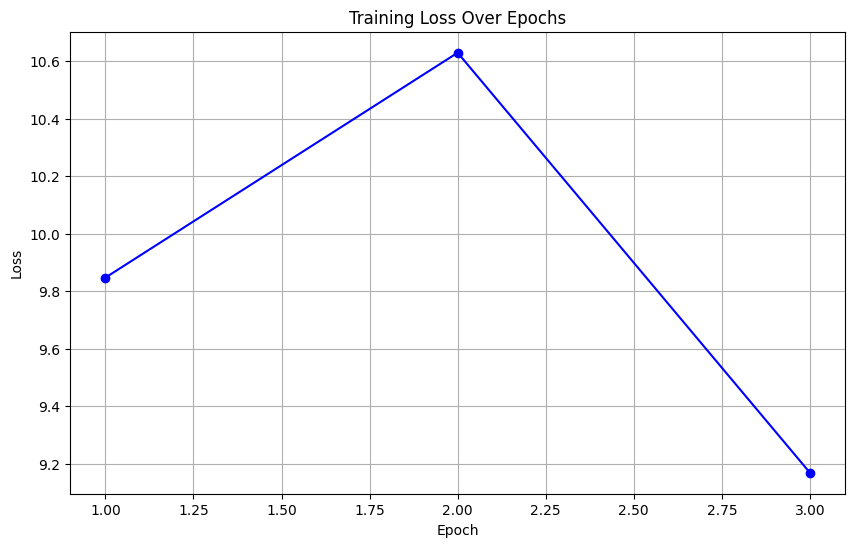

In [23]:
import matplotlib.pyplot as plt

loss_values = []


for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for batch in dataloader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        masked_labels = batch['masked_labels'].to(device)
        print("label = ",labels)
        print("masked label =",masked_labels)
        
        loss, logits = model(labels, masked_labels, compute_loss=True)

        
        loss.backward()
        optimizer.step()

        
        total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    loss_values.append(avg_loss)  
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}')
# 

model.eval()
with torch.no_grad():
    for batch in dataloader:
        input_ids = batch['input_ids'].to(device)
        labels = batch['labels'].to(device)
        masked_labels = batch['masked_labels'].to(device)
        
        logits = model(labels, compute_loss=False)
        print("Predictions:", logits)
        
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), loss_values, marker='o', linestyle='-', color='b')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.show()
